# Libraries

In [1]:
from mnist import MNIST
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from statsmodels.tsa.api import VAR

In [2]:
mndata = MNIST('./Data')
images, labels = mndata.load_training()
labels = labels.tolist()

In [3]:
# Organizing the data
images = [x for _,x in sorted(zip(labels,images))]
labels.sort()
label_counts = list(Counter(labels).values())
num_cycles = 200

tensor_shape = (num_cycles*10, 28, 28)
data = np.empty(tensor_shape)

# Makes the cycle
for i in range(num_cycles):
    for j in range(10):
        offset = sum(label_counts[:j]) + i
        tmp = np.asarray(images[offset])
        tmp.resize((tensor_shape[1], tensor_shape[2]))
        data[i*10 + j] = tmp

In [4]:
N = len(data)
N_train = N - 10
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 2000
N_train: 1990
N_test: 10


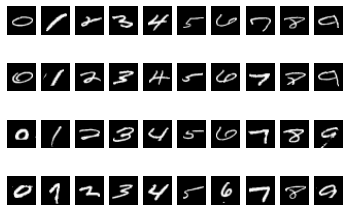

In [5]:
def implot_tensor(tensor, fig_dim, cmap='gray'):
    fig, axs = plt.subplots(fig_dim[0], fig_dim[1])
    for i in range(fig_dim[0]):
        for j in range(fig_dim[1]):
            axs[i, j].imshow(tensor[i*fig_dim[1] + j], cmap='gray')
            axs[i, j].axis('off')
    
implot_tensor(data, (4, 10))

In [6]:
train_tensor = jts.extract_train_tensor(data, N_train)
test_tensor = jts.extract_test_tensor(data, N_train, N_test)

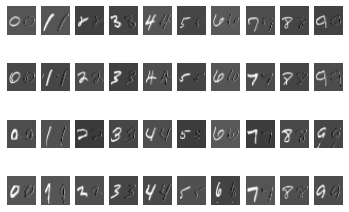

In [7]:
train_dwt = jts.apply_dwt_to_tensor(train_tensor)
implot_tensor(train_dwt, (4, 10))

In [8]:
train_model_sets = jts.split_cols_into_model_sets(train_dwt, N_train)
test_model_sets = jts.split_cols_into_model_sets(test_tensor, N_test)

In [10]:
interval = 10
train_model_sets_seasonal_diff = np.empty((tensor_shape[2], N_train - interval, tensor_shape[1]))
for i in range(28):
    df = pd.DataFrame(train_model_sets[i])
    train_model_sets_seasonal_diff[i] = jts.calc_seasonal_diff(df, interval)

In [11]:
train_model_sets_seasonal_diff

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

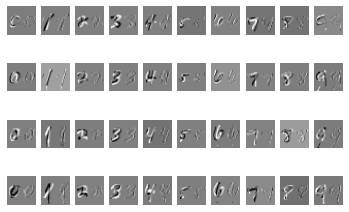

In [13]:
implot_tensor(tmp_tensor, (4, 10))

In [51]:
result_model_sets = np.empty((tensor_shape[2], N_test, tensor_shape[1]))
result_model_sets_dwt_seasonal_diff = np.empty((tensor_shape[2], N_test, tensor_shape[1]))

for i in range(28):
    train_df = pd.DataFrame(train_model_sets_seasonal_diff[i])
    test_df = pd.DataFrame(test_model_sets[i])
    model = VAR(train_df)
    fit = model.fit(1)

    test_df.columns = test_df.columns[:].astype(str)
    results_seasonal_diff = jts.forecast(fit, train_df, test_df, N_test, calc_conf = False)
    result_model_sets_dwt_seasonal_diff[i] = results_seasonal_diff

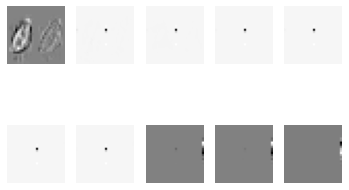

In [52]:
result_dwt_seasonal_tensor = jts.collect_result_cols_into_tensor(result_model_sets_dwt_seasonal_diff, N_test)
implot_tensor(result_dwt_seasonal_tensor, (2, 5))

In [53]:
result_dwt_tensor = jts.collect_result_cols_into_tensor(result_model_sets, N_test)

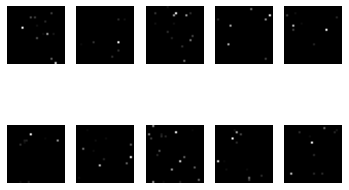

In [54]:
implot_tensor(result_dwt_tensor, (2, 5))

In [55]:
result_tensor = jts.apply_inverse_dwt_to_tensor(result_dwt_tensor)

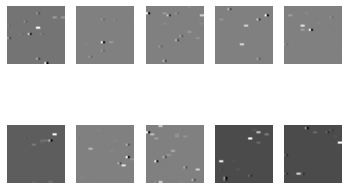

In [56]:
implot_tensor(result_tensor, (2, 5))

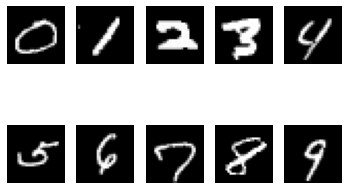

In [57]:
implot_tensor(train_tensor[-10:], (2, 5))